In [6]:
%load_ext autoreload
%autoreload 2
%matplotlib inline
from collections import OrderedDict
from IPython.display import display
from joblib import dump, load
from sklearn import metrics
from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier
from sklearn.model_selection import train_test_split, cross_val_score, cross_val_predict, RandomizedSearchCV, GridSearchCV
from sklearn.preprocessing import PowerTransformer, QuantileTransformer, StandardScaler
from sklearn.decomposition import PCA
from sklearn.datasets import make_regression
from sklearn.pipeline import Pipeline

import ipyparallel as ipp
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd
import itertools

import MESS
from MESS.util import set_params

## Set some pandas options to show the full rows and columns of a DF
pd.set_option('display.max_columns', 500)
pd.set_option('display.max_rows', 100)
pd.set_option('display.width', 1000)

## Where do you want the simulation output to life?
analysis_dir = "/home/isaac/Continuosity/MESS/analysis/"
analysis_dir = analysis_dir + "/full-parameter-estimation/"
if not os.path.exists(analysis_dir):
    os.mkdir(analysis_dir)

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [19]:
ipyclient = ipp.Client(cluster_id="MESS-Rich")
print(len(ipyclient))

40


In [32]:
r = MESS.Region("whole_enchilada")
## Region params
r.set_param("project_dir", analysis_dir)
r.set_param("generations", 0)
r.set_param("community_assembly_model", "neutral")
r.set_param("mutation_rate", 2.2e-8)
r.set_param("alpha", (500, 5000))

## Metacommunity Params
r.set_param("S_m", 500)
r.set_param("J_m", (5e4, 5e6))
r.set_param("speciation_rate", 2)
r.set_param("death_proportion", 0.7)
r.set_param("trait_rate_meta", 2)
r.set_param("ecological_strength", (1, 10))

## Local Params
r.set_param("J", 1000)
r.set_param("m", (0.001, 0.01))
r.set_param("speciation_prob", (0.0001, 0.001))
r.set_param("background_death", 0.25)

r.write_params(full=True, force=True)
#r.run(sims=1000, ipyclient=ipyclient)

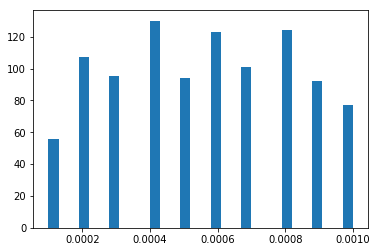

In [20]:
neut_file = analysis_dir + "SIMOUT.txt"
filt_file = analysis_dir + "filt/SIMOUT.txt"
comp_file = analysis_dir + "comp/SIMOUT.txt"

sim_df = pd.read_csv(neut_file, sep="\t", header=0)
_, _, _ = plt.hist(sim_df["speciation_prob"], bins=30)

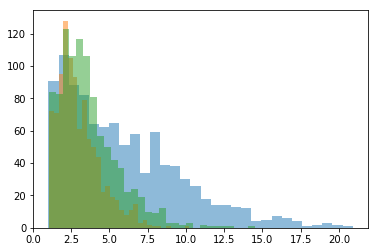

In [48]:
for f in [neut_file, filt_file, comp_file]:
    sim_df = pd.read_csv(f, sep="\t", header=0)[:1000]
    plt.hist(sim_df["abund_h1"], alpha=.5, bins=30)

In [21]:
def get_best_params(Xtrain, ytrain, n_iter=100):
    n_estimators = [int(x) for x in np.linspace(start = 200, stop = 2000, num = 10)]
    max_depth = [int(x) for x in np.linspace(10, 110, num = 11)]
    max_depth.append(None)
    min_samples_split = [2, 5, 10]
    min_samples_leaf = [1, 2, 4]
    bootstrap = [True, False]
    random_grid = {'n_estimators': n_estimators,
                   'max_depth': max_depth,
                   'min_samples_split': min_samples_split,
                   'min_samples_leaf': min_samples_leaf,
                   'bootstrap': bootstrap}

    ## Randomly search 100 different parameter combinations and take the
    ## one that reduces CV error
    rf_random = RandomizedSearchCV(estimator = RandomForestRegressor(),\
                                   param_distributions = random_grid,
                                   n_iter = n_iter, cv = 3, verbose=0, n_jobs = -1)
    rf_random.fit(Xtrain, ytrain)
    return rf_random.best_estimator_

def plot_cv_pred(y, cv_preds, targets, verbose=False):
    fig, axs = plt.subplots(2, 3, figsize=(10, 5))
    axs = axs.flatten()
    lims = {"m":0.01, "speciation_prob":0.001}
    for i, p in enumerate(targets):
        ax = axs[i]
        vscore = metrics.explained_variance_score(y.iloc[:, i], cv_preds[:, i])
        r2 = metrics.r2_score(y.iloc[:, i], cv_preds[:, i])
        if verbose: print("\tparam: {}\tvscore: {}\tr2: {}".format(p, vscore, r2))
        ax.scatter(y.iloc[:, i], cv_preds[:, i], c='black', marker='.', s=2)
        ax.set_title(p)
        if p in ["m", "speciation_prob"]:
            ax.set_xlim(0, lims[p])
            ax.set_ylim(0, lims[p])
    return fig

In [22]:
feature_sets = OrderedDict({})
feature_sets["abund"] = ["S"] + [x for x in sim_df.columns if "abund" in x]
feature_sets["pi"] = [x for x in sim_df.columns if "pi" in x or "SGD" in x]
feature_sets["abund+pi"] =  feature_sets["abund"] + feature_sets["pi"]
feature_sets["pi+dxy"] = feature_sets["pi"] + [x for x in sim_df.columns if "dxy" in x]
feature_sets["all"] = sim_df.iloc[:, 22:].columns

In [23]:
for i, (f, features) in enumerate(feature_sets.items()):
    print(i, f, len(features))

(0, 'abund', 5)
(1, 'pi', 20)
(2, 'abund+pi', 25)
(3, 'pi+dxy', 26)
(4, 'all', 54)


In [ ]:
## be smarter to add a codeblock here to run, generate the analysis directories per model,
## train the RF, and then dump it to a file, then in the following block we can just load
## in the pre-trained model and throw data at it. Saves time.

In [30]:

outdir = analysis_dir + "cv_figs/"
if not os.path.exists(outdir):
    os.mkdir(outdir)
targets = ["alpha", "J_m", "ecological_strength", "m", "speciation_prob", "_lambda"]

## Infile is the input SIMOUT file. model_name is either neutral, comp, or filt
## for labeling the figures
def joint_param_cv(infile, outdir=outdir, model_name='', use_features=["abund"],
                   n_iter=100, n_samps=1e6, verbose=False):
    model_outdir = os.path.join(outdir, model_name)
    if not os.path.exists(model_outdir):
        os.mkdir(model_outdir)
    n_samps=int(n_samps)
    sim_df = pd.read_csv(infile, sep="\t", header=0)
    print("Model: {}\tTotal sims: {}\t Sims to use: {}\t N param CV iters: {}".format(model_name, len(sim_df), n_samps, n_iter))
    imp_out_df = pd.DataFrame([], index=feature_sets["all"])
    
    for f in use_features:
        features = feature_sets[f]
        X = sim_df[features][:n_samps]
        y = sim_df[targets][:n_samps]
        Xtrain, Xtest, ytrain, ytest = train_test_split(X, y)
        print("{}: Finding best model params".format(f))
        model = get_best_params(Xtrain, ytrain, n_iter=n_iter)
        print("{}: Best params - {}".format(f, model.get_params()))
        dump(model, "{}/{}.mdl".format(model_outdir, f)) 
        feat_imp_df = pd.DataFrame(model.feature_importances_, index=features, columns=[f])
        imp_out_df = pd.concat([imp_out_df, feat_imp_df], axis=1, sort=False)
        #display(feat_imp_df.sort_values(0, ascending=False).T)
        cv_preds = cross_val_predict(model, X, y, cv=5, n_jobs=-1)
        fig = plot_cv_pred(y, cv_preds, targets, verbose=verbose)
        plt.suptitle(f)
        plt.tight_layout()
        plt.savefig("{}/{}.png".format(model_outdir, f))
    imp_out_df.to_csv(model_outdir + model_name + "_feature_importance.csv", sep="\t")

Model: neut	Total sims: 999	 Sims to use: 1000	 N param CV iters: 2
abund: Finding best model params
abund: Best params - {'warm_start': False, 'oob_score': False, 'n_jobs': None, 'min_impurity_decrease': 0.0, 'verbose': 0, 'max_leaf_nodes': None, 'bootstrap': False, 'min_samples_leaf': 4, 'n_estimators': 2000, 'min_samples_split': 10, 'min_weight_fraction_leaf': 0.0, 'criterion': 'mse', 'random_state': None, 'min_impurity_split': None, 'max_features': 'auto', 'max_depth': None}
	param: alpha	vscore: -0.180763021326	r2: -0.180779567308
	param: J_m	vscore: -0.528056389435	r2: -0.528104957558
	param: ecological_strength	vscore: -0.173176098705	r2: -0.173797743324
	param: m	vscore: 0.466428803236	r2: 0.466181860625
	param: speciation_prob	vscore: -0.121932028547	r2: -0.121954565057
	param: _lambda	vscore: 0.848373331537	r2: 0.84821217349


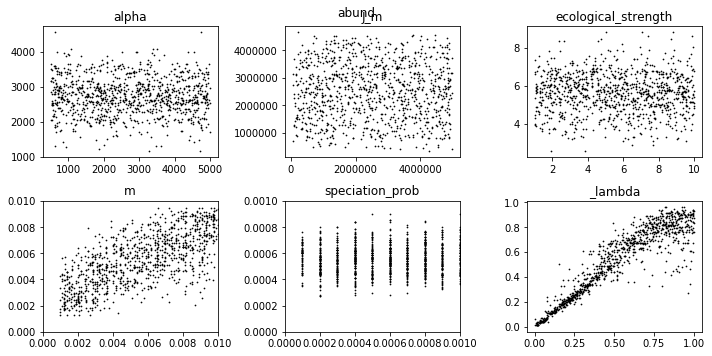

In [31]:
## Make these params v small for prototyping
n_iter=2
n_samps=1e3
joint_param_cv(infile=neut_file, outdir=outdir, model_name="neut", n_iter=n_iter, n_samps=n_samps, verbose=True)

## Do all the big joint parameter estimation CVs and plots
We're going to do serious CV now, so set the n_iter and n_samps to reasonably large vals.

Model: neut	Total sims: 11168	 Sims to use: 10000	 N param CV iters: 100
abund: Finding best model params
pi: Finding best model params
abund+pi: Finding best model params
pi+dxy: Finding best model params
all: Finding best model params
Model: filt	Total sims: 996	 Sims to use: 10000	 N param CV iters: 100
abund: Finding best model params
pi: Finding best model params
abund+pi: Finding best model params
pi+dxy: Finding best model params
all: Finding best model params
Model: comp	Total sims: 1994	 Sims to use: 10000	 N param CV iters: 100
abund: Finding best model params
pi: Finding best model params
abund+pi: Finding best model params
pi+dxy: Finding best model params
all: Finding best model params


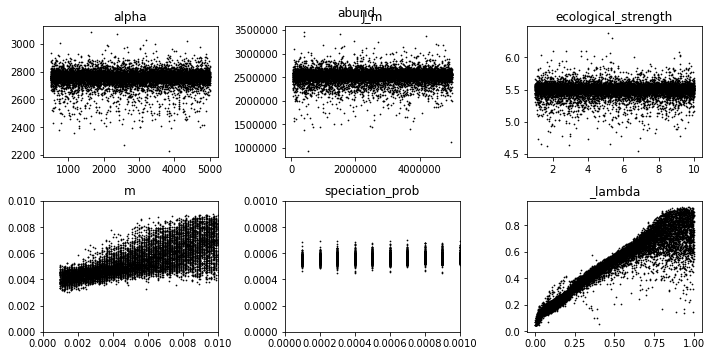

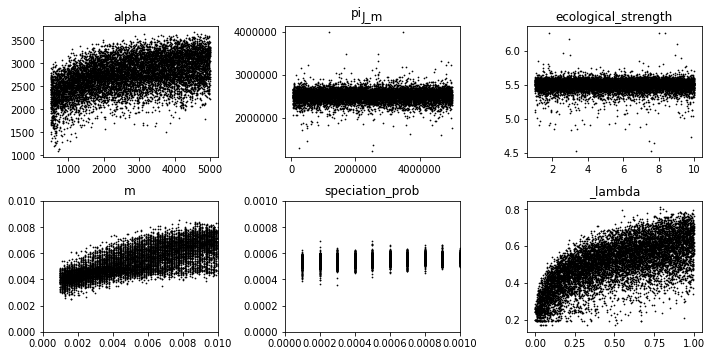

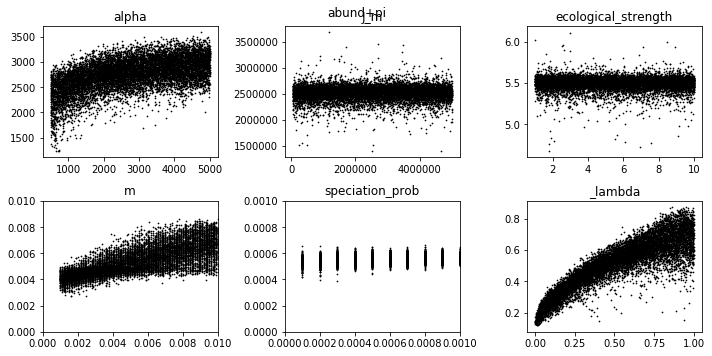

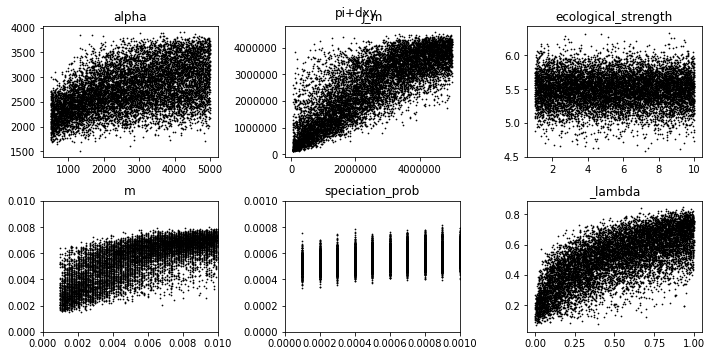

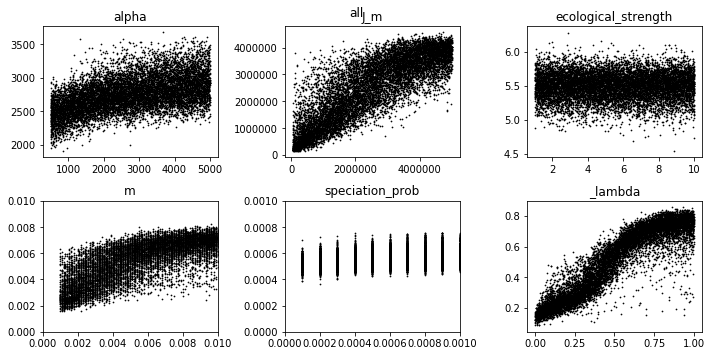

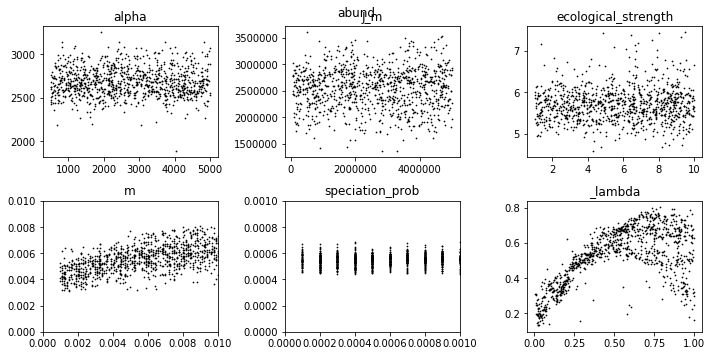

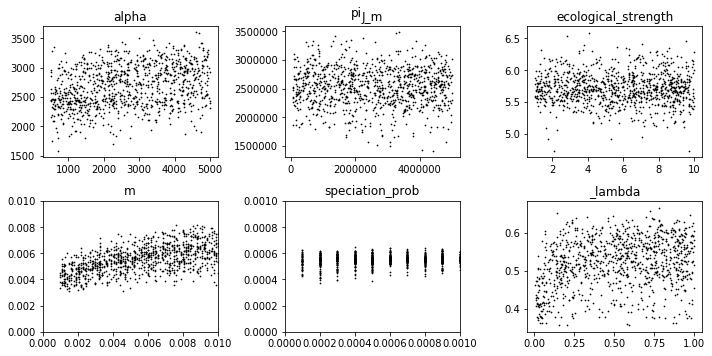

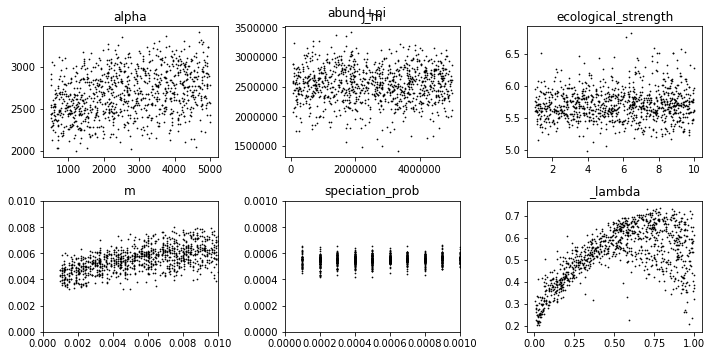

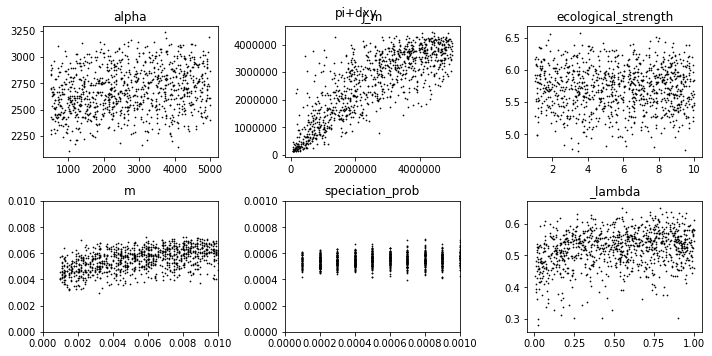

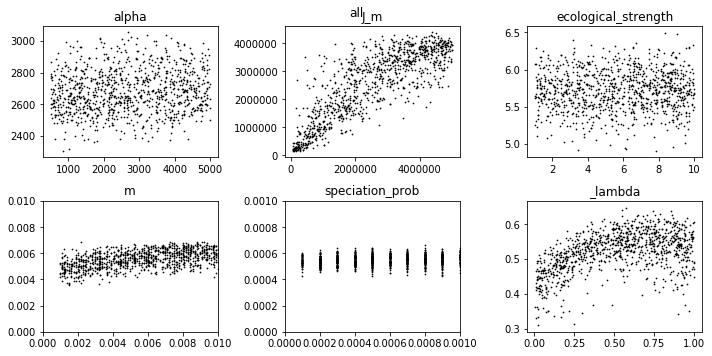

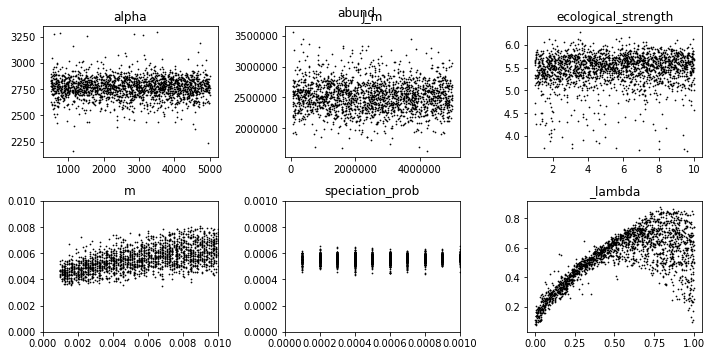

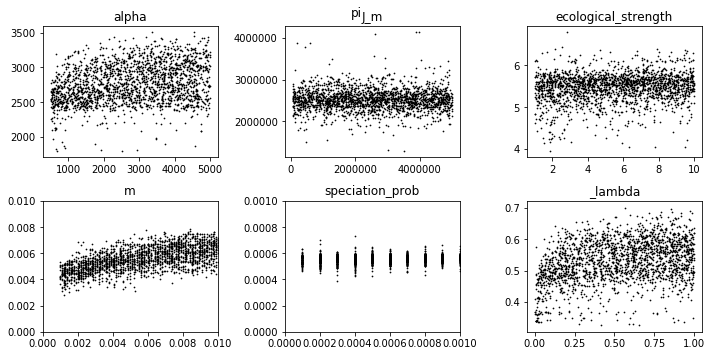

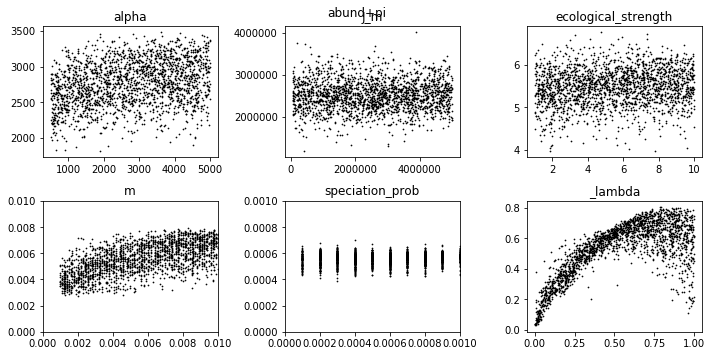

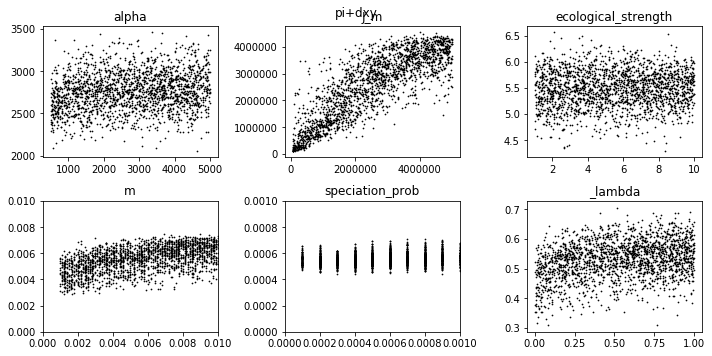

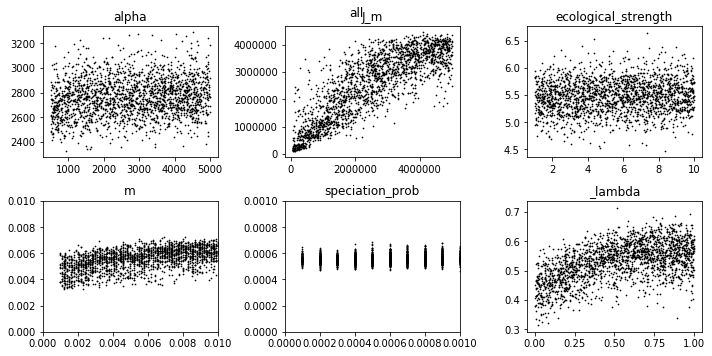

In [17]:
n_iter=100
n_samps=10000
joint_param_cv(infile=neut_file, outdir=outdir, model_name="neut", n_iter=n_iter, n_samps=n_samps)
joint_param_cv(infile=filt_file, outdir=outdir, model_name="filt", n_iter=n_iter, n_samps=n_samps)
joint_param_cv(infile=comp_file, outdir=outdir, model_name="comp", n_iter=n_iter, n_samps=n_samps)

## Estimate each parameter independently

In [43]:

outdir = analysis_dir + "independent_cv_figs/"
if not os.path.exists(outdir):
    os.mkdir(outdir)
targets = ["alpha", "J_m", "ecological_strength", "m", "speciation_prob", "_lambda"]

def plot_independent_cv_pred(ax, y, cv_preds, target_label, verbose=False):

    lims = {"m":0.01, "speciation_prob":0.001}
    vscore = metrics.explained_variance_score(y, cv_preds)
    r2 = metrics.r2_score(y, cv_preds)
    if verbose: print("\tparam: {}\tvscore: {}\tr2: {}".format(target_label, vscore, r2))
    ax.scatter(y, cv_preds, c='black', marker='.', s=2)
    ax.set_title(target_label)
    if target_label in ["m", "speciation_prob"]:
        ax.set_xlim(0, lims[target_label])
        ax.set_ylim(0, lims[target_label])

## Infile is the input SIMOUT file. model_name is either neutral, comp, or filt
## for labeling the figures
def independent_param_cv(infile, outdir=outdir, model_name='', use_features=["abund"],
                   n_iter=100, n_samps=1e6, verbose=False):
    model_outdir = os.path.join(outdir, model_name)
    if not os.path.exists(model_outdir):
        os.mkdir(model_outdir)
    n_samps=int(n_samps)
    sim_df = pd.read_csv(infile, sep="\t", header=0)
    print("Model: {}\tTotal sims: {}\t Sims to use: {}\t N param CV iters: {}".format(model_name, len(sim_df), n_samps, n_iter))
    imp_out_df = pd.DataFrame([], index=feature_sets["all"])
    
    for f in use_features:
        ## Here we know there are six targets
        fig, axs = plt.subplots(2, 3, figsize=(10, 5))
        axs = axs.flatten()
        features = feature_sets[f]
        for fidx, target in enumerate(targets):
            X = sim_df[features][:n_samps]
            y = sim_df[target][:n_samps]
            Xtrain, Xtest, ytrain, ytest = train_test_split(X, y)
            print("{} {}: Finding best model params".format(f, target))
            model = get_best_params(Xtrain, ytrain, n_iter=n_iter)
            print("{} {}: Best params - {}".format(f, target, model.get_params()))
            dump(model, "{}/{}_{}.mdl".format(model_outdir, f, target)) 
            feat_imp_df = pd.DataFrame(model.feature_importances_, index=features, columns=[f])
            imp_out_df = pd.concat([imp_out_df, feat_imp_df], axis=1, sort=False)
            #display(feat_imp_df.sort_values(0, ascending=False).T)
            cv_preds = cross_val_predict(model, X, y, cv=5, n_jobs=-1)
            fig = plot_independent_cv_pred(axs[fidx], y, cv_preds, target_label=target, verbose=verbose)
            plt.suptitle(f)
            plt.tight_layout()
            plt.savefig("{}/{}.png".format(model_outdir, f))
        imp_out_df.to_csv("{}/{}_{}_feature_importance.csv".format(model_outdir, model_name, f), sep="\t")

Model: filt	Total sims: 999	 Sims to use: 1000	 N param CV iters: 2
all alpha: Finding best model params


/home/isaac/miniconda2/envs/MESS/lib/python2.7/site-packages/sklearn/model_selection/_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


all alpha: Best params - {'warm_start': False, 'oob_score': False, 'n_jobs': None, 'min_impurity_decrease': 0.0, 'verbose': 0, 'max_leaf_nodes': None, 'bootstrap': True, 'min_samples_leaf': 2, 'n_estimators': 800, 'min_samples_split': 5, 'min_weight_fraction_leaf': 0.0, 'criterion': 'mse', 'random_state': None, 'min_impurity_split': None, 'max_features': 'auto', 'max_depth': 10}
	param: alpha	vscore: 0.369028633704	r2: 0.368994124151
all J_m: Finding best model params
all J_m: Best params - {'warm_start': False, 'oob_score': False, 'n_jobs': None, 'min_impurity_decrease': 0.0, 'verbose': 0, 'max_leaf_nodes': None, 'bootstrap': False, 'min_samples_leaf': 4, 'n_estimators': 1600, 'min_samples_split': 2, 'min_weight_fraction_leaf': 0.0, 'criterion': 'mse', 'random_state': None, 'min_impurity_split': None, 'max_features': 'auto', 'max_depth': 30}
	param: J_m	vscore: 0.384838787084	r2: 0.384816925977
all ecological_strength: Finding best model params


/home/isaac/miniconda2/envs/MESS/lib/python2.7/site-packages/sklearn/model_selection/_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


all ecological_strength: Best params - {'warm_start': False, 'oob_score': False, 'n_jobs': None, 'min_impurity_decrease': 0.0, 'verbose': 0, 'max_leaf_nodes': None, 'bootstrap': False, 'min_samples_leaf': 4, 'n_estimators': 600, 'min_samples_split': 2, 'min_weight_fraction_leaf': 0.0, 'criterion': 'mse', 'random_state': None, 'min_impurity_split': None, 'max_features': 'auto', 'max_depth': 60}
	param: ecological_strength	vscore: -0.783488489309	r2: -0.783505147666
all m: Finding best model params
all m: Best params - {'warm_start': False, 'oob_score': False, 'n_jobs': None, 'min_impurity_decrease': 0.0, 'verbose': 0, 'max_leaf_nodes': None, 'bootstrap': True, 'min_samples_leaf': 1, 'n_estimators': 1000, 'min_samples_split': 5, 'min_weight_fraction_leaf': 0.0, 'criterion': 'mse', 'random_state': None, 'min_impurity_split': None, 'max_features': 'auto', 'max_depth': 10}
	param: m	vscore: 0.650599408033	r2: 0.650399250127
all speciation_prob: Finding best model params
all speciation_prob:

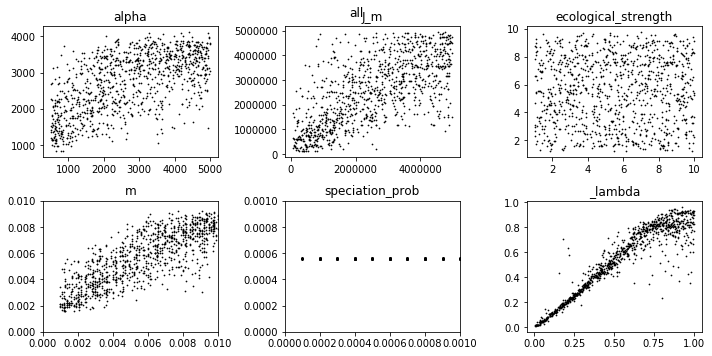

In [44]:
## Make these params v small for prototyping
n_iter=2
n_samps=1e3
independent_param_cv(infile=neut_file, outdir=outdir, model_name="filt",\
                     use_features=["all"], n_iter=n_iter, n_samps=n_samps, verbose=True)

## Dev below here
This is just prototyping of all the small chunks that got chunked together in the main codeblock above.

In [82]:
features = sim_df.iloc[:, 22:].columns

## Parameters to estimate
targets = ["alpha", "J_m", "ecological_strength", "m", "speciation_prob", "_lambda"]

X = sim_df[features]
y = sim_df[targets]

## Split the data
Xtrain, Xtest, ytrain, ytest = train_test_split(X, y)
display(Xtrain[:5])
display(ytrain[:5])

,S,abund_h1,abund_h2,abund_h3,abund_h4,pi_h1,pi_h2,pi_h3,pi_h4,mean_pi,std_pi,skewness_pi,kurtosis_pi,median_pi,iqr_pi,mean_dxys,std_dxys,skewness_dxys,kurtosis_dxys,median_dxys,iqr_dxys,trees,mean_local_traits,std_local_traits,skewness_local_traits,kurtosis_local_traits,median_local_traits,iqr_local_traits,mean_regional_traits,std_regional_traits,skewness_regional_traits,kurtosis_regional_traits,median_regional_traits,iqr_regional_traits,reg_loc_mean_trait_dif,reg_loc_std_trait_dif,reg_loc_skewness_trait_dif,reg_loc_kurtosis_trait_dif,reg_loc_median_trait_dif,reg_loc_iqr_trait_dif,SGD_0,SGD_1,SGD_2,SGD_3,SGD_4,SGD_5,SGD_6,SGD_7,SGD_8,SGD_9
331,22.0,11.5090,9.3053,8.3236,7.7153,3.5717,3.1758,2.8784,2.6800,0.0001,0.0002,2.7467,7.1915,0.0000,0.0000,0.0051,0.0069,2.8625,8.7762,0.0030,0.0056,0.0,-0.9836,3.3354,-0.5613,-0.3924,-1.1075,5.0872,-1.2970,3.5926,-0.1317,-0.3190,-1.1089,4.8567,-0.3134,0.2572,0.4296,0.0734,-0.0013,-0.2304,18.0,0.0,0.0,3.0,0.0,0.0,0.0,0.0,0.0,1.0
933,16.0,5.6307,3.3462,2.6832,2.4251,7.4810,7.0431,6.7023,6.4474,0.0003,0.0003,0.6162,-1.0724,0.0002,0.0004,0.0135,0.0176,1.7014,1.5942,0.0059,0.0164,0.0,-0.8028,3.0603,0.0117,-1.0581,-1.3781,4.4892,-0.7000,2.8862,0.1536,-0.4897,-0.6997,4.1873,0.1027,-0.1741,0.1419,0.5685,0.6784,-0.3019,8.0,0.0,0.0,0.0,4.0,0.0,0.0,2.0,0.0,2.0
13,28.0,3.4978,1.8125,1.5768,1.4994,6.5585,6.2060,5.9338,5.7249,0.0002,0.0003,1.6307,1.2162,0.0000,0.0001,0.0016,0.0019,1.4657,1.2900,0.0009,0.0020,0.0,-1.1165,2.2590,-0.0438,-0.9734,-1.0809,3.5629,-1.1475,2.6991,0.0852,-0.1759,-1.2075,4.0720,-0.0311,0.4401,0.1289,0.7975,-0.1266,0.5091,21.0,0.0,0.0,2.0,0.0,0.0,3.0,0.0,0.0,2.0
66,24.0,7.8985,4.6650,3.6942,3.2827,8.6832,6.9159,5.8015,5.1432,0.0004,0.0006,2.2415,5.3539,0.0000,0.0006,0.0020,0.0024,1.3591,0.6399,0.0010,0.0022,0.0,0.3711,5.8165,-0.6095,-0.1919,0.6980,5.3730,-0.5742,6.1348,-0.3725,-0.5866,0.3937,8.7988,-0.9454,0.3183,0.2370,-0.3948,-0.3042,3.4258,13.0,4.0,2.0,2.0,2.0,0.0,0.0,0.0,0.0,1.0
535,7.0,1.3917,1.1461,1.1093,1.0966,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,-3.0000,0.0000,0.0000,0.0141,0.0143,1.9241,1.9120,0.0100,0.0047,0.0,-0.3722,2.6683,0.7948,-0.4607,-1.1670,3.0783,-0.3349,3.6320,-0.5066,0.3769,0.1453,4.7499,0.0374,0.9637,-1.3014,0.8376,1.3124,1.6716,0.0,0.0,0.0,0.0,0.0,7.0,0.0,0.0,0.0,0.0


,alpha,J_m,ecological_strength,m,speciation_prob,_lambda
331,939,1718863,3.9828,0.0055,0.0008,0.926
933,991,3595529,4.0502,0.0049,0.0002,0.520
13,2326,1312734,5.5901,0.0082,0.0010,0.265
66,2586,1343852,6.6803,0.0051,0.0006,0.607
535,2120,4948555,6.9824,0.0097,0.0009,0.027


In [83]:
n_estimators = [int(x) for x in np.linspace(start = 200, stop = 2000, num = 10)]
max_depth = [int(x) for x in np.linspace(10, 110, num = 11)]
max_depth.append(None)
min_samples_split = [2, 5, 10]
min_samples_leaf = [1, 2, 4]
bootstrap = [True, False]
random_grid = {'n_estimators': n_estimators,
               'max_depth': max_depth,
               'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf,
               'bootstrap': bootstrap}

## Randomly search 100 different parameter combinations and take the
## one that reduces CV error
rf_random = RandomizedSearchCV(estimator = RandomForestRegressor(),\
                               param_distributions = random_grid,
                               n_iter = 100, cv = 3, verbose=0, n_jobs = -1)
rf_random.fit(Xtrain, ytrain)

RandomizedSearchCV(cv=3, error_score='raise-deprecating',
          estimator=RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
           max_features='auto', max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=1, min_samples_split=2,
           min_weight_fraction_leaf=0.0, n_estimators='warn', n_jobs=None,
           oob_score=False, random_state=None, verbose=0, warm_start=False),
          fit_params=None, iid='warn', n_iter=100, n_jobs=-1,
          param_distributions={'n_estimators': [200, 400, 600, 800, 1000, 1200, 1400, 1600, 1800, 2000], 'min_samples_split': [2, 5, 10], 'bootstrap': [True, False], 'max_depth': [10, 20, 30, 40, 50, 60, 70, 80, 90, 100, 110, None], 'min_samples_leaf': [1, 2, 4]},
          pre_dispatch='2*n_jobs', random_state=None, refit=True,
          return_train_score='warn', scoring=None, verbose=0)

In [101]:
model = rf_random.best_estimator_
ypred = model.predict(Xtest)

#print(model.feature_importances_)
#print(metrics.explained_variance_score(ypred, ytest))
#print(metrics.r2_score(ypred, ytest)) 
pd.DataFrame(model.feature_importances_, index=features).sort_values(0, ascending=False).T

,mean_dxys,median_dxys,kurtosis_dxys,abund_h4,reg_loc_std_trait_dif,iqr_dxys,SGD_0,kurtosis_regional_traits,skewness_regional_traits,reg_loc_kurtosis_trait_dif,std_pi,std_dxys,S,abund_h3,skewness_dxys,iqr_regional_traits,iqr_pi,skewness_local_traits,reg_loc_mean_trait_dif,reg_loc_iqr_trait_dif,reg_loc_median_trait_dif,abund_h2,mean_pi,median_pi,reg_loc_skewness_trait_dif,std_local_traits,kurtosis_local_traits,iqr_local_traits,mean_regional_traits,std_regional_traits,mean_local_traits,median_regional_traits,skewness_pi,median_local_traits,kurtosis_pi,abund_h1,pi_h1,pi_h4,SGD_2,SGD_1,SGD_5,pi_h2,SGD_3,pi_h3,SGD_6,SGD_4,SGD_9,SGD_8,SGD_7,trees
0,0.666214,0.054891,0.015956,0.012981,0.012723,0.012535,0.012061,0.012004,0.011832,0.009544,0.009149,0.008731,0.008397,0.008264,0.008084,0.007885,0.007569,0.00753,0.007518,0.006821,0.006468,0.005836,0.00573,0.005708,0.005618,0.005333,0.005154,0.004911,0.004846,0.004446,0.004382,0.004335,0.004222,0.004135,0.004062,0.004027,0.002484,0.002183,0.002087,0.002069,0.001983,0.00198,0.00161,0.001602,0.001232,0.001121,0.000876,0.000562,0.00031,0.0


In [85]:
scores = cross_val_score(model, X, y, cv=5, n_jobs=-1)
scores

array([0.55567373, 0.64707322, 0.6446963 , 0.67257785, 0.68624674])

In [86]:
cv_preds = cross_val_predict(model, X, y, cv=5, n_jobs=-1)
cv_preds[:2]

array([[2.91124719e+03, 3.25457359e+06, 5.68348536e+00, 4.72666545e-03,
        5.86574948e-04, 5.75507119e-01],
       [3.02390820e+03, 4.05509522e+05, 5.33665951e+00, 6.79118056e-03,
        5.40778478e-04, 3.63868498e-01]])

('alpha', 0.09913367002477425, 0.099107781282053)
('J_m', 0.6436414418725183, 0.6436222030938098)
('ecological_strength', -0.01244018929438706, -0.012453414135890295)
('m', 0.3748076431310253, 0.3747724387196084)
('speciation_prob', 0.04854086005807645, 0.04852659382037261)
('_lambda', 0.5936215006328769, 0.5936147908114506)


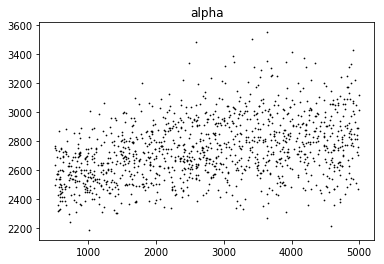

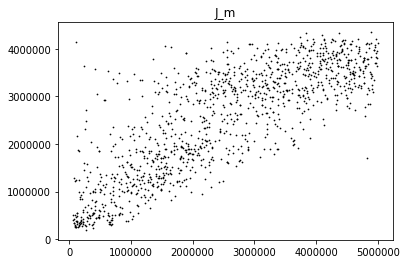

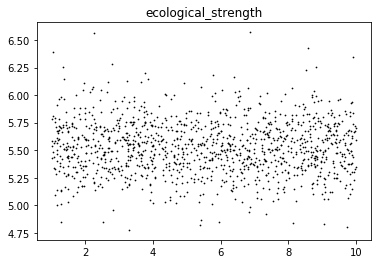

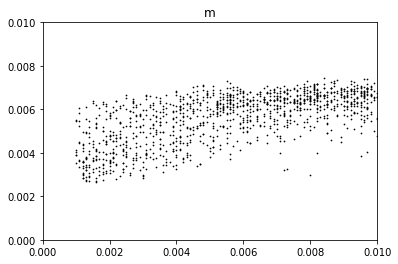

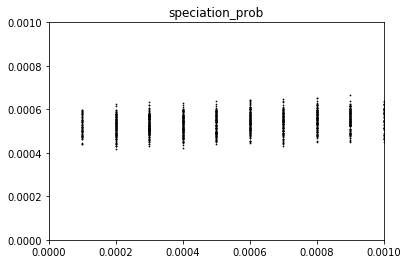

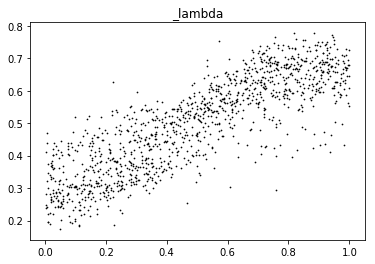

In [92]:
lims = {"m":0.01, "speciation_prob":0.001}
for i, p in enumerate(targets):
    fig, ax = plt.subplots()
    vscore = metrics.explained_variance_score(y.iloc[:, i], cv_preds[:, i])
    r2 = metrics.r2_score(y.iloc[:, i], cv_preds[:, i])
    print(p, vscore, r2)
    ax.scatter(y.iloc[:, i], cv_preds[:, i], c='black', marker='.', s=2)
    ax.set_title(p)
    if p in ["m", "speciation_prob"]:
        ax.set_xlim(0, lims[p])
        ax.set_ylim(0, lims[p])

In [108]:
[x for x in sim_df.columns if "pi" in x or "SGD" in x]

['pi_h1',
 'pi_h2',
 'pi_h3',
 'pi_h4',
 'mean_pi',
 'std_pi',
 'skewness_pi',
 'kurtosis_pi',
 'median_pi',
 'iqr_pi',
 'SGD_0',
 'SGD_1',
 'SGD_2',
 'SGD_3',
 'SGD_4',
 'SGD_5',
 'SGD_6',
 'SGD_7',
 'SGD_8',
 'SGD_9']